<h1 style="text-align: center; font-weight: bold;">
Experiments Model LSTM 
</h1>


# LLibreries

In [169]:
# üì¶ Gesti√≥ b√†sica de dades i formats
import os
import json
import random
import warnings
from datetime import datetime
from itertools import combinations

# üìä Tractament i visualitzaci√≥ de dades
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter, MaxNLocator
import seaborn as sns
import plotly.express as px

# Configuraci√≥ visuals
%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings("ignore")  # Ignorar warnings per evitar soroll

# üìà Barra de progr√©s
from tqdm.notebook import tqdm

# üß™ Preprocessament i m√®triques
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error)

# ü§ñ TensorFlow i Keras ‚Äî Xarxes LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Dropout, LSTM
from keras import Model


# Funcions pr√≤pies
import importlib
import lstm_functions
importlib.reload(lstm_functions)
from lstm_functions import *



# Importaci√≥ Dades

Dades Carregades des del fitxer CSV netejat i guardat pel fitxer de data preprocessing

In [162]:
#Directori de treball

# Ruta on esta el script actual
__path__ = os.getcwd() # Si es fitxer .ipynb
# __path__ = os.path.dirname(os.path.realpath(__file__)) # Si es fitxer .py

# Carpeta on es troben les dades
carpeta_dades = '../0_Data/Dades_T_estacions_xema_Z1'

# Fitxers de dades
fitxer_dades_csv = 'SCM_T_Z1.csv' # Nom del fitxer CSV amb totes les dades
fitxer_dades_csv_2009_2019 = 'SCM_T_Z1_2009_2019.csv' # Nom del fitxer CSV amb les dades de 2009 a 2019
fitxer_dades_csv_2020_2024 = 'SCM_T_Z1_2020_2024.csv' # Nom del fitxer CSV amb les dades de 2020 a 2024 (final dades)

# Path complet al fitxer CSV
path_dades = os.path.join(__path__, carpeta_dades, fitxer_dades_csv)
path_dades_2009_2019 = os.path.join(__path__, carpeta_dades, fitxer_dades_csv_2009_2019)
path_dades_2020_2024 = os.path.join(__path__, carpeta_dades, fitxer_dades_csv_2020_2024)


# Importar les dades 2020_2024 per LSTM ja que son recents i no tenen interrupcions ni valors nuls

df_lstm = pd.read_csv(path_dades_2020_2024)

# Convertir la columna 'data' a tipus datetime
df_lstm['data'] = pd.to_datetime(df_lstm['data'], utc=True)

# Comprovar si hi ha valors nuls
print("Valors nuls per columna en dades LSTM:")
print(df_lstm.isnull().sum())

# Mostrar el df

df_lstm


Valors nuls per columna en dades LSTM:
data     0
valor    0
dtype: int64


data  valor
0     2020-01-01 00:00:00+00:00   1.30
1     2020-01-01 01:00:00+00:00   1.60
2     2020-01-01 02:00:00+00:00   3.20
3     2020-01-01 03:00:00+00:00   4.40
4     2020-01-01 04:00:00+00:00   4.00
...                         ...    ...
43843 2024-12-31 19:00:00+00:00   0.10
43844 2024-12-31 20:00:00+00:00  -0.60
43845 2024-12-31 21:00:00+00:00  -0.60
43846 2024-12-31 22:00:00+00:00  -0.70
43847 2024-12-31 23:00:00+00:00  -0.80

[43848 rows x 2 columns]

### Visualitzaci√≥ Pr√®via de les dades

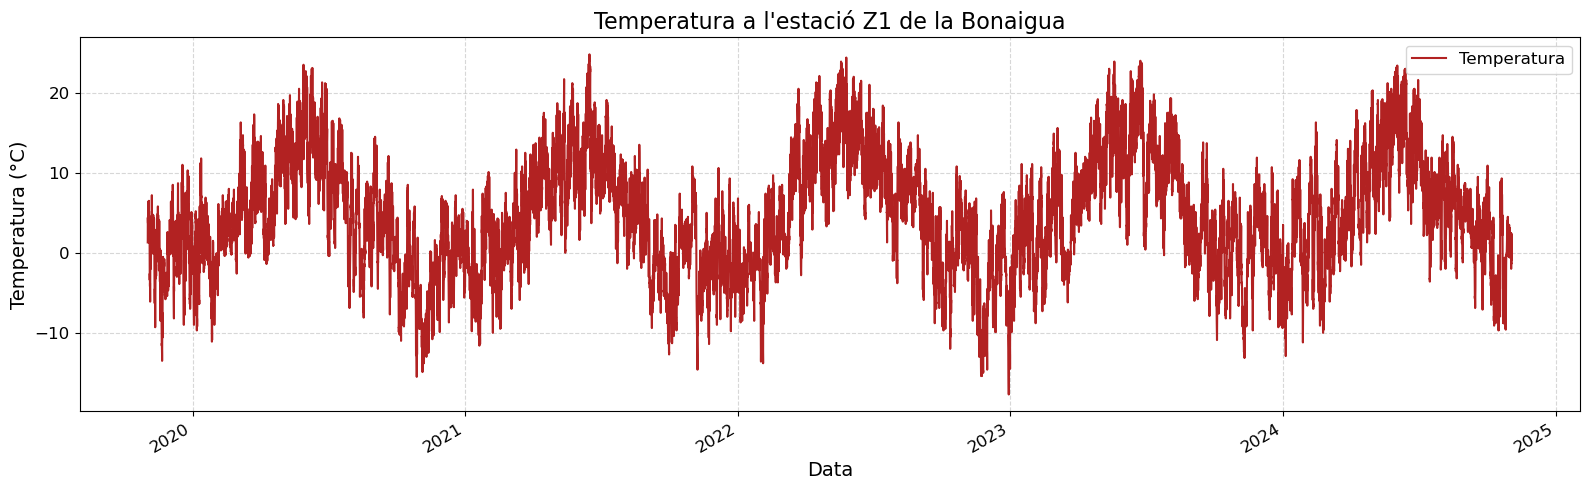

In [117]:
plt.figure(figsize=(16, 5))
plt.plot(df_lstm['data'], df_lstm['valor'], label='Temperatura', color='firebrick', linewidth=1.5)

# Millores visuals
plt.title('Temperatura a l\'estaci√≥ Z1 de la Bonaigua', fontsize=16)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Temperatura (¬∞C)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)

# Format de dates a l‚Äôeix X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

# Experimentaci√≥ amb Varies configuracions LSTM usant Pipeline  

| ID | `window_size` | `n_outputs` | `n_layers` | `n_units` | `dropout` | Estrat√®gies de predicci√≥ |
| -- | ------------- | ----------- | ---------- | --------- | --------- | ------------------------ |
| 0  | 24            | 1           | 1          | 1         | 0.2       | batch, iter, reinject    |
| 1  | 24            | 1           | 1          | 32        | 0.2       | batch, iter, reinject    |
| 2  | 48            | 1           | 2          | 64        | 0.2       | batch, iter, reinject    |
| 3  | 72            | 1           | 3          | 128       | 0.2       | batch, iter, reinject    |
| 4  | 48            | 6           | 2          | 64        | 0.2       | batch                    |
| 5  | 96            | 12          | 3          | 128       | 0.2       | batch                    |


In [ ]:
# Parametres Globals del model LSTM

# Parametres influents del model LSTM (Cal fer proves)

WINDOW_SIZE = [24, 48, 72, 96]   # Nombre de mostres per finestra temporal
N_OUTPUTS = [1, 6, 12]            # Nombre de mostres a predir (1h, 6h, 12h) (multioutput o unioutput)
N_LAYERS = [1, 2, 3]              # Nombre de capes LSTM
N_UNITS = [32, 64, 128]           # Nombre de neurones per capa LSTM


# Parametres menys influents del model LSTM (no cal tocar-los gaire)

N_FEATURES = 1                    # Nombre de caracter√≠stiques d'entrada (temperatura
N_SLIDE = N_OUTPUTS               # Despla√ßament de la finestra temporal (per defecte igual a N_OUTPUTS)
BATCH_SIZE = 128                  # Mida del lot batch per l'entrenament
DROPOUT = [0.0, 0.1, 0.2]        # Taxa de dropout per evitar sobreajustament
EPOCHS = 50                       # Nombre d'√®poques per l'entrenament
PATIENCE = 5                      # Paciencia per l'early stopping
PREDICTIONS_MOD = [               # Tipus de predicci√≥ a realitzar
            'pred_batch',
            'pred_iter',
            'pred_reinject'
            ]        


In [ ]:
# Directoris dels experiments per guardar els models i resultats

#Carpeta resultats experiments (save_path per la pipeline)
carpeta_resultats = 'models_results_experiments'

## Experiment 0: LSTM with 1 Layer and 1 Unit (BASE)

In [10]:
# Nom de la carpeta per l'experiment
carpeta_experiment = 'experiment_0'
path_experiment = os.path.join(__path__, carpeta_resultats, carpeta_experiment) # Path complet a la carpeta de l'experiment


# Parametres influents del model LSTM (Experiment base minimalista)

WINDOW_SIZE = 24                # Nombre de mostres per finestra (24 hores)
N_OUTPUTS = 1                   # Predicci√≥ d'1 hora vista
N_LAYERS = 1                    # Nom√©s una capa LSTM
N_UNITS = 1                     # Una sola neurona
DROPOUT_RATE = 0.2              # Dropout per estabilitzar (tot i ser petit)

# Parametres menys influents (es deixen fixos)

BATCH_SIZE = 128                # Batch gran per estabilitat
EPOCHS = 50                     # Entrenament complet
PATIENCE = 5                    # EarlyStopping
N_SLIDE = N_OUTPUTS             # Per predicci√≥ puntual
N_FEATURES = 1                  # Una sola variable (temperatura)
PREDICTIONS_MOD = [
    'pred_batch',
    'pred_iter',
    'pred_reinject'
]

üß† [1/5] Entrenant el model LSTM...
‚úÖ Escalat completat:


Train dataset shape: (39432, 3)
Validation dataset shape: (2208, 3)
Test dataset shape: (2208, 3)
Entrenant el model LSTM
Epoch 1/50
308/308 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 3ms/step - loss: 0.0629 - val_loss: 0.0122
Epoch 2/50
308/308 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 3ms/step - loss: 0.0192 - val_loss: 0.0066
Epoch 3/50
308/308 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 3ms/step - loss: 0.0100 - val_loss: 0.0049
Epoch 4/50
308/308 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 3ms/step - loss: 0.0085 - val_loss: 0.0046
Epoch 5/50
308/308 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 3ms/step - loss: 0.0081 - val_loss: 0.0048
Epoch 6/50
308/308 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 3ms/step - loss: 0.0079 - val_loss: 0.0053
Epoch 7/50
308/308 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚

Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ lstm (LSTM)                     ‚îÇ (None, 1)              ‚îÇ            12 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 1)              ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                   ‚îÇ (None, 1)              ‚îÇ             2 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 44 (180.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 30 (124.00 B)

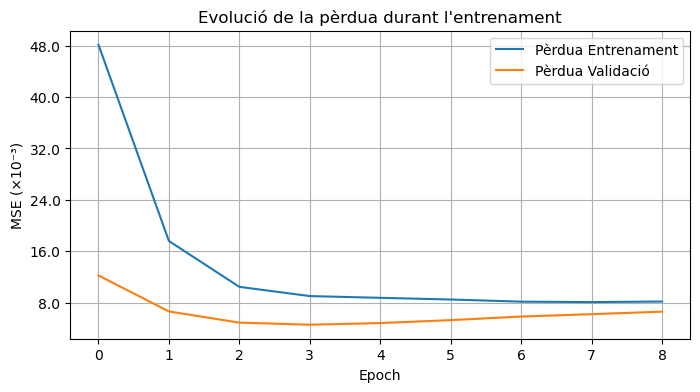

Entrenament completat.
üíæ [2/5] Guardant model i gr√†fica de p√®rdua...
üîÆ [3/5] Fent prediccions...
Fent predicci√≥ batch...
Fent predicci√≥ iterativa...
Fent predicci√≥ iterativa amb reinjecci√≥...
üìä [4/5] Generant gr√†fic de prediccions...


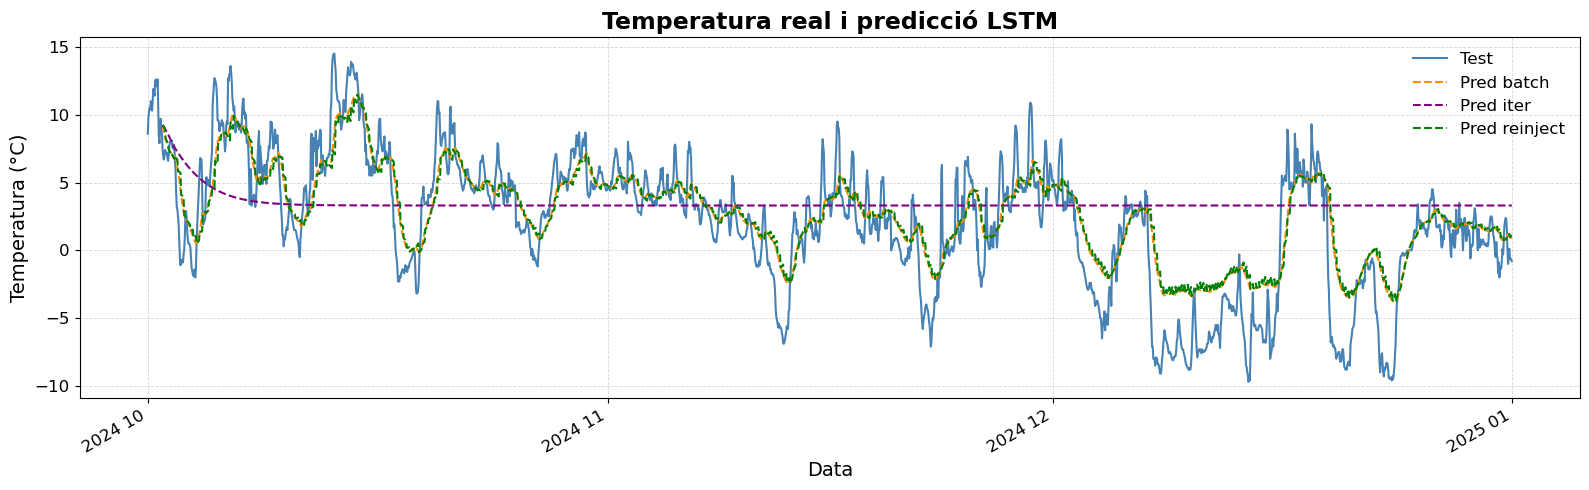

üóÉÔ∏è [5/5] Guardant prediccions, m√®triques i configuraci√≥...


In [ ]:

model, scaler, df_train, df_val, df_test_pred, history, metriques, fig, fig_loss_train = pipeline_lstm(
    df_lstm=df_lstm,
    window_size=WINDOW_SIZE,     
    n_outputs=N_OUTPUTS,
    n_layers=N_LAYERS,
    n_units=N_UNITS,        
    dropout_rate=DROPOUT_RATE,
    optimizer='adam',
    loss='mse',
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    patience=PATIENCE,
    shuffle=False,
    seed=42,
    dies_train=0,
    mostrar_val=False,
    col_preds=PREDICTIONS_MOD,
    save_path=path_experiment,
    show=True,
    summary=True
)


## Experiments 1-5: LSTM with Varying Parameters

In [ ]:

EXPERIMENTS = [1, 2, 3, 4, 5] # Llista d'experiments a realitzar (per iterar sobre els par√†metres)

# Llistes de par√†metres per experiments definits manualment

WINDOW_SIZES =    [24, 24, 48, 72, 48, 96]
N_OUTPUTS_LIST =  [ 1,  1,  1,  1,  6, 12]
N_LAYERS_LIST =   [ 1,  1,  2,  3,  2,  3]
N_UNITS_LIST =    [ 1, 32, 64,128, 64,128]


DROPOUT_RATE = 0.2
BATCH_SIZE = 128                # Batch gran per estabilitat
EPOCHS = 50                     # Entrenament complet
PATIENCE = 5                    # EarlyStopping
N_SLIDE = N_OUTPUTS                     # Per predicci√≥ puntual (igual a N_OUTPUTS)
N_FEATURES = 1                  # Una sola variable (temperatura)
PREDICTIONS_MOD = [
    'pred_batch',
    'pred_iter',
    'pred_reinject'
]



In [17]:
for i in EXPERIMENTS:
    
    print(f"\nüöÄ Executant experiment {i}...")

    # Agafar par√†metres per aquest experiment
    window_size = WINDOW_SIZES[i]
    n_outputs = N_OUTPUTS_LIST[i]
    n_layers = N_LAYERS_LIST[i]
    n_units = N_UNITS_LIST[i]

    # Nom de la carpeta per a l'experiment
    carpeta_exp = f"experiment_{i}"
    path_experiment = os.path.join(__path__, carpeta_resultats, carpeta_exp)
    os.makedirs(path_experiment, exist_ok=True)

    
    # Executar pipeline
    model, scaler, df_train, df_val, df_test_pred, history, metriques, fig, fig_loss_train = pipeline_lstm(
        df_lstm=df_lstm,
        window_size=window_size,
        n_outputs=n_outputs,
        n_layers=n_layers,
        n_units=n_units,
        dropout_rate=DROPOUT_RATE,
        optimizer='adam',
        loss='mse',
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        patience=PATIENCE,
        shuffle=False,
        seed=42,
        dies_train=0,
        mostrar_val=False,
        col_preds= PREDICTIONS_MOD,
        save_path=path_experiment,
        show=True,
        summary=False
    )

    print(f"‚úÖ Experiment {i} completat i guardat a: {path_experiment}")



üöÄ Executant experiment 1...
üß† [1/5] Entrenant el model LSTM...
‚úÖ Escalat completat:


Train dataset shape: (39432, 3)
Validation dataset shape: (2208, 3)
Test dataset shape: (2208, 3)
Entrenant el model LSTM
Epoch 1/50
308/308 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 7ms/step - loss: 0.0549 - val_loss: 0.0051
Epoch 2/50
308/308 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 6ms/step - loss: 0.0064 - val_loss: 0.0036
Epoch 3/50
308/308 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 7ms/step - loss: 0.0046 - val_loss: 0.0026
Epoch 4/50
308/308 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 7ms/step - loss: 0.0037 - val_loss: 0.0015
Epoch 5/50
308/308 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 7ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 6/50
308/308 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 7ms/step - loss: 0.0026 - val_loss: 0.0011
Epoch 7/50
308/308 ‚îÅ‚îÅ‚î

Entrenament completat.
üíæ [2/5] Guardant model i gr√†fica de p√®rdua...
üîÆ [3/5] Fent prediccions...
Fent predicci√≥ batch...
Fent predicci√≥ iterativa...
Fent predicci√≥ iterativa amb reinjecci√≥...
üìä [4/5] Generant gr√†fic de prediccions...

üìà M√®triques calculades:
         pred_batch  pred_iter  pred_reinject
M√®trica                                      
RMSE           0.80      12.39           1.81
MSE            0.64     153.44           3.28
MAE            0.57      11.35           1.35
üóÉÔ∏è [5/5] Guardant prediccions, m√®triques i configuraci√≥...
‚úÖ Experiment 1 completat i guardat a: /home/prp/Escriptori/TFM_SCM_Temperature_Forecasting_ML/models_prediccio/3_model_lstm/models_results_experiments/experiment_1

üöÄ Executant experiment 2...
üß† [1/5] Entrenant el model LSTM...
‚úÖ Escalat completat:


Train dataset shape: (39432, 3)
Validation dataset shape: (2208, 3)
Test dataset shape: (2208, 3)
Entrenant el model LSTM
Epoch 1/50
308/308 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚

Entrenament completat.
üíæ [2/5] Guardant model i gr√†fica de p√®rdua...
üîÆ [3/5] Fent prediccions...
Fent predicci√≥ batch...
Fent predicci√≥ iterativa...
Fent predicci√≥ iterativa amb reinjecci√≥...
üìä [4/5] Generant gr√†fic de prediccions...

üìà M√®triques calculades:
         pred_batch  pred_iter  pred_reinject
M√®trica                                      
RMSE           0.77      11.56           1.61
MSE            0.60     133.59           2.60
MAE            0.53      10.40           1.13
üóÉÔ∏è [5/5] Guardant prediccions, m√®triques i configuraci√≥...
‚úÖ Experiment 2 completat i guardat a: /home/prp/Escriptori/TFM_SCM_Temperature_Forecasting_ML/models_prediccio/3_model_lstm/models_results_experiments/experiment_2

üöÄ Executant experiment 3...
üß† [1/5] Entrenant el model LSTM...
‚úÖ Escalat completat:


Train dataset shape: (39432, 3)
Validation dataset shape: (2208, 3)
Test dataset shape: (2208, 3)
Entrenant el model LSTM
Epoch 1/50
308/308 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚

Entrenament completat.
üíæ [2/5] Guardant model i gr√†fica de p√®rdua...
üîÆ [3/5] Fent prediccions...
Fent predicci√≥ batch...
Fent predicci√≥ iterativa...
Fent predicci√≥ iterativa amb reinjecci√≥...
üìä [4/5] Generant gr√†fic de prediccions...

üìà M√®triques calculades:
         pred_batch  pred_iter  pred_reinject
M√®trica                                      
RMSE           0.77      10.63           1.64
MSE            0.59     113.08           2.70
MAE            0.53       9.47           1.17
üóÉÔ∏è [5/5] Guardant prediccions, m√®triques i configuraci√≥...
‚úÖ Experiment 3 completat i guardat a: /home/prp/Escriptori/TFM_SCM_Temperature_Forecasting_ML/models_prediccio/3_model_lstm/models_results_experiments/experiment_3

üöÄ Executant experiment 4...
üß† [1/5] Entrenant el model LSTM...
‚úÖ Escalat completat:


Train dataset shape: (39432, 3)
Validation dataset shape: (2208, 3)
Test dataset shape: (2208, 3)
Entrenant el model LSTM
Epoch 1/50
52/52 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

Entrenament completat.
üíæ [2/5] Guardant model i gr√†fica de p√®rdua...
üîÆ [3/5] Fent prediccions...
Fent predicci√≥ batch multi-output...
üìä [4/5] Generant gr√†fic de prediccions...

üìà M√®triques calculades:
         pred_batch
M√®trica            
RMSE           1.65
MSE            2.71
MAE            1.18
üóÉÔ∏è [5/5] Guardant prediccions, m√®triques i configuraci√≥...
‚úÖ Experiment 4 completat i guardat a: /home/prp/Escriptori/TFM_SCM_Temperature_Forecasting_ML/models_prediccio/3_model_lstm/models_results_experiments/experiment_4

üöÄ Executant experiment 5...
üß† [1/5] Entrenant el model LSTM...
‚úÖ Escalat completat:


Train dataset shape: (39432, 3)
Validation dataset shape: (2208, 3)
Test dataset shape: (2208, 3)
Entrenant el model LSTM
Epoch 1/50
26/26 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 330ms/step - loss: 0.1099 - val_loss: 0.0193
Epoch 2/50
26/26 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 295ms/step - loss: 0.015

Entrenament completat.
üíæ [2/5] Guardant model i gr√†fica de p√®rdua...
üîÆ [3/5] Fent prediccions...
Fent predicci√≥ batch multi-output...
üìä [4/5] Generant gr√†fic de prediccions...

üìà M√®triques calculades:
         pred_batch
M√®trica            
RMSE           3.14
MSE            9.88
MAE            2.33
üóÉÔ∏è [5/5] Guardant prediccions, m√®triques i configuraci√≥...
‚úÖ Experiment 5 completat i guardat a: /home/prp/Escriptori/TFM_SCM_Temperature_Forecasting_ML/models_prediccio/3_model_lstm/models_results_experiments/experiment_5


## Experiments 0-5: Variant paramentres amb Lookahead 6

| ID | `window_size` | `n_outputs` | `n_layers` | `n_units` | `dropout` | `lookahead` | Estrat√®gies de predicci√≥ |
| -- | ------------- | ----------- | ---------- | --------- | --------- | ----------- | ------------------------ |
| 0  | 24            | 1           | 1          | 1         | 0.2       | 6           | batch, iter, reinject    |
| 1  | 24            | 1           | 1          | 32        | 0.2       | 6           | batch, iter, reinject    |
| 2  | 48            | 1           | 2          | 64        | 0.2       | 6           | batch, iter, reinject    |
| 3  | 72            | 1           | 3          | 128       | 0.2       | 6           | batch, iter, reinject    |
| 4  | 48            | 6           | 2          | 64        | 0.2       | 6           | batch                    |
| 5  | 96            | 12          | 3          | 128       | 0.2       | 6           | batch                    |



In [ ]:
# Directoris dels experiments per guardar els models i resultats

#Carpeta resultats experiments (save_path per la pipeline)
carpeta_resultats = 'models_results_experiments_lookahead'


EXPERIMENTS = [1, 2, 3, 4, 5] # Llista d'experiments a realitzar (per iterar sobre els par√†metres)

# Llistes de par√†metres per experiments definits manualment

WINDOW_SIZE =    [24, 24, 48, 72, 48, 96]
N_OUTPUTS =  [ 1,  1,  1,  1,  6, 12]
N_LAYERS =   [ 1,  1,  2,  3,  2,  3]
N_UNITS =    [ 1, 32, 64,128, 64,128]
LOOKAHEAD = 6

DROPOUT_RATE = 0.2
BATCH_SIZE = 128                # Batch gran per estabilitat
EPOCHS = 50                     # Entrenament complet
PATIENCE = 5                    # EarlyStopping
N_SLIDE = N_OUTPUTS             # Per predicci√≥ puntual (igual a N_OUTPUTS)
N_FEATURES = 1                  # Una sola variable (temperatura)
PREDICTIONS_MOD = [
    'pred_batch',
    'pred_reinject'
]




üöÄ Executant experiment 1...
üß† [1/5] Entrenant el model LSTM...
‚úÖ Escalat completat:


Train dataset shape: (39432, 3)
Validation dataset shape: (2208, 3)
Test dataset shape: (2208, 3)
Entrenant el model LSTM
Epoch 1/50
308/308 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 6ms/step - loss: 0.0234 - val_loss: 0.0074
Epoch 2/50
308/308 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 6ms/step - loss: 0.0082 - val_loss: 0.0072
Epoch 3/50
308/308 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 6ms/step - loss: 0.0076 - val_loss: 0.0071
Epoch 4/50
308/308 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 6ms/step - loss: 0.0071 - val_loss: 0.0070
Epoch 5/50
308/308 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 6ms/step - loss: 0.0067 - val_loss: 0.0066
Epoch 6/50
308/308 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 6ms/step - loss: 0.0062 - val_loss: 0.0050
Epoch 7/50
308/308 ‚îÅ‚îÅ‚î

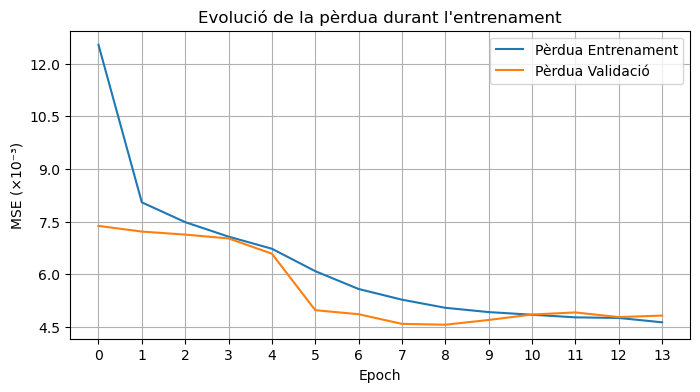

Entrenament completat.
üíæ [2/5] Guardant model i gr√†fica de p√®rdua...
üîÆ [3/5] Fent prediccions...
Fent predicci√≥ batch...
Fent predicci√≥ iterativa...
Fent predicci√≥ iterativa amb reinjecci√≥...
üìä [4/5] Generant gr√†fic de prediccions...


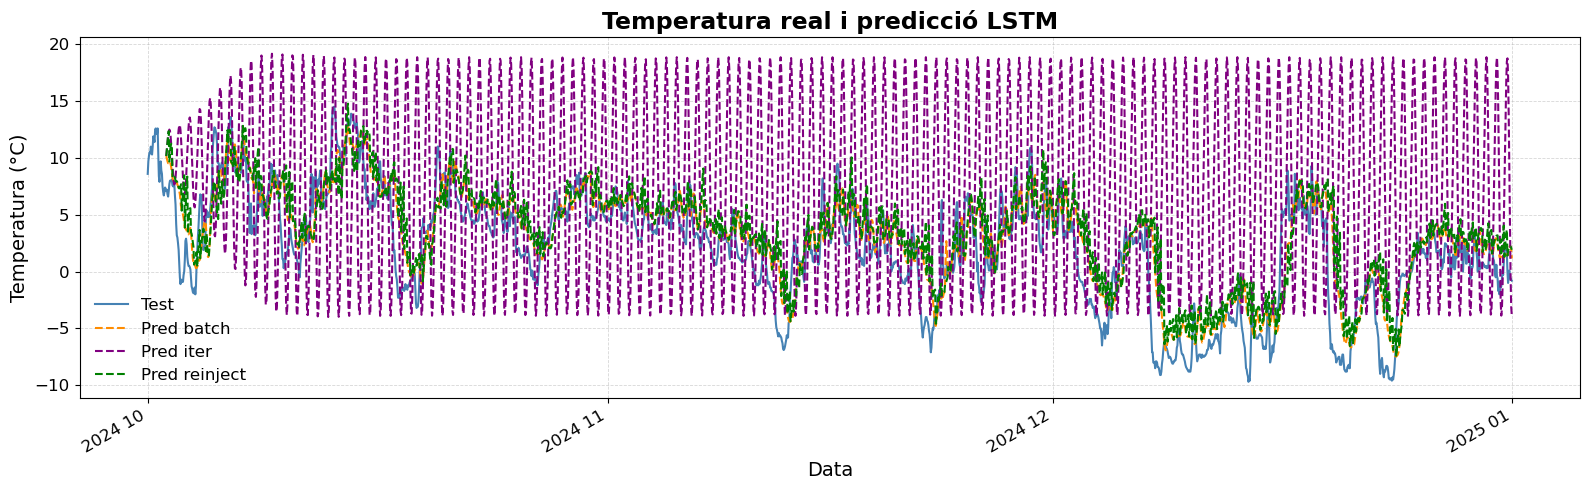


üìà M√®triques calculades:
         pred_batch  pred_iter  pred_reinject
M√®trica                                      
RMSE           2.74      10.66           3.39
MSE            7.51     113.59          11.52
MAE            2.11       8.73           2.59
üóÉÔ∏è [5/5] Guardant prediccions, m√®triques i configuraci√≥...
‚úÖ Experiment 1 completat i guardat a: /home/prp/Escriptori/TFM_SCM_Temperature_Forecasting_ML/models_prediccio/3_model_lstm/models_results_experiments_lookahead/experiment_1

üöÄ Executant experiment 2...
üß† [1/5] Entrenant el model LSTM...
‚úÖ Escalat completat:


Train dataset shape: (39432, 3)
Validation dataset shape: (2208, 3)
Test dataset shape: (2208, 3)
Entrenant el model LSTM
Epoch 1/50
308/308 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 16s 45ms/step - loss: 0.0152 - val_loss: 0.0073
Epoch 2/50
308/308 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 14s 45ms/step - loss: 0.0073 - val_loss: 0.0048
Epoch 3/50
308/308 ‚îÅ‚îÅ

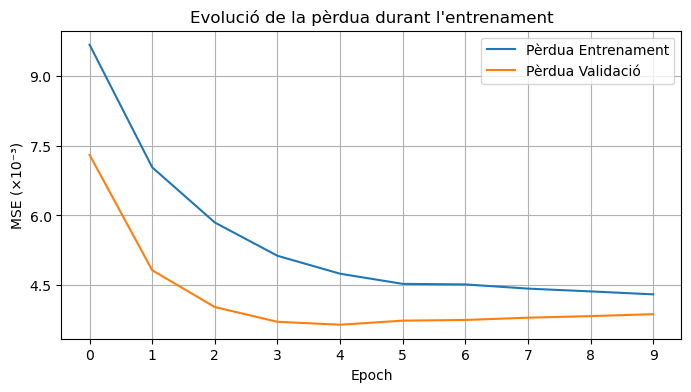

Entrenament completat.
üíæ [2/5] Guardant model i gr√†fica de p√®rdua...
üîÆ [3/5] Fent prediccions...
Fent predicci√≥ batch...
Fent predicci√≥ iterativa...
Fent predicci√≥ iterativa amb reinjecci√≥...
üìä [4/5] Generant gr√†fic de prediccions...


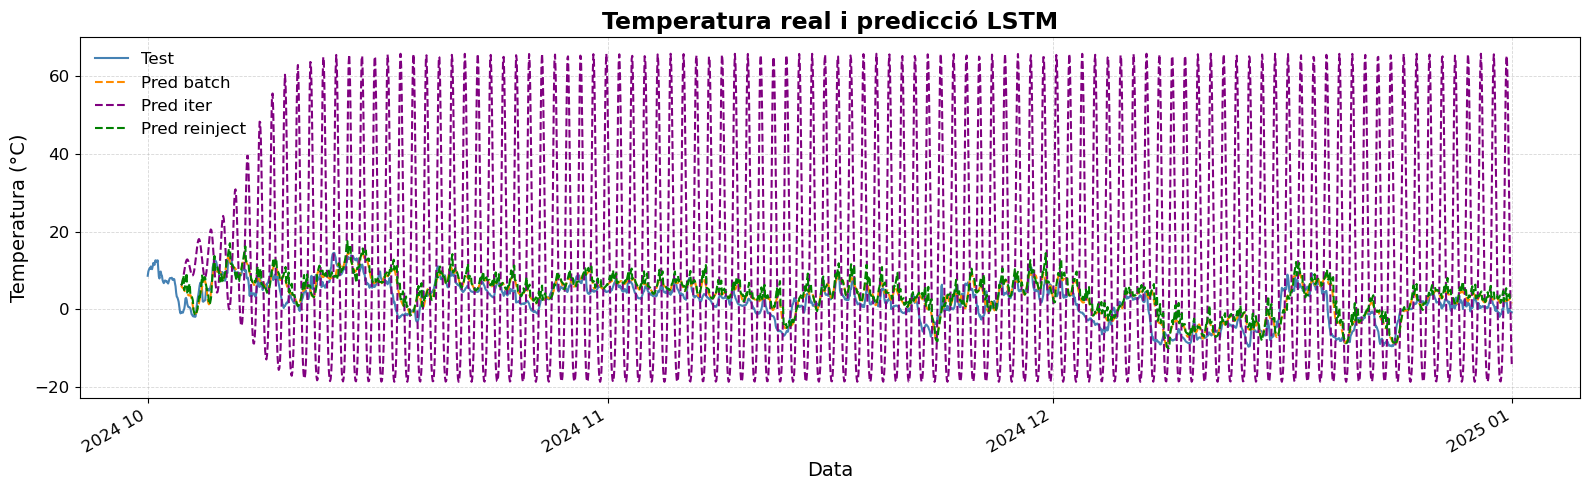


üìà M√®triques calculades:
         pred_batch  pred_iter  pred_reinject
M√®trica                                      
RMSE           2.89      32.41           3.67
MSE            8.34    1050.54          13.45
MAE            2.25      25.86           2.89
üóÉÔ∏è [5/5] Guardant prediccions, m√®triques i configuraci√≥...
‚úÖ Experiment 2 completat i guardat a: /home/prp/Escriptori/TFM_SCM_Temperature_Forecasting_ML/models_prediccio/3_model_lstm/models_results_experiments_lookahead/experiment_2

üöÄ Executant experiment 3...
üß† [1/5] Entrenant el model LSTM...
‚úÖ Escalat completat:


Train dataset shape: (39432, 3)
Validation dataset shape: (2208, 3)
Test dataset shape: (2208, 3)
Entrenant el model LSTM
Epoch 1/50
308/308 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 70s 220ms/step - loss: 0.0170 - val_loss: 0.0073
Epoch 2/50
308/308 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 66s 213ms/step - loss: 0.0077 - val_loss: 0.0053
Epoch 3/50
308/308 ‚îÅ‚

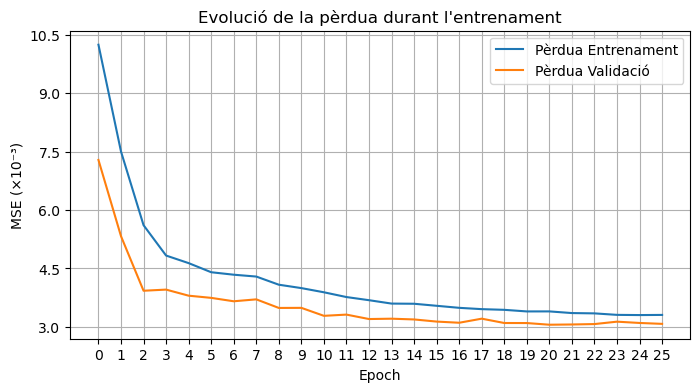

Entrenament completat.
üíæ [2/5] Guardant model i gr√†fica de p√®rdua...
üîÆ [3/5] Fent prediccions...
Fent predicci√≥ batch...
Fent predicci√≥ iterativa...
Fent predicci√≥ iterativa amb reinjecci√≥...
üìä [4/5] Generant gr√†fic de prediccions...


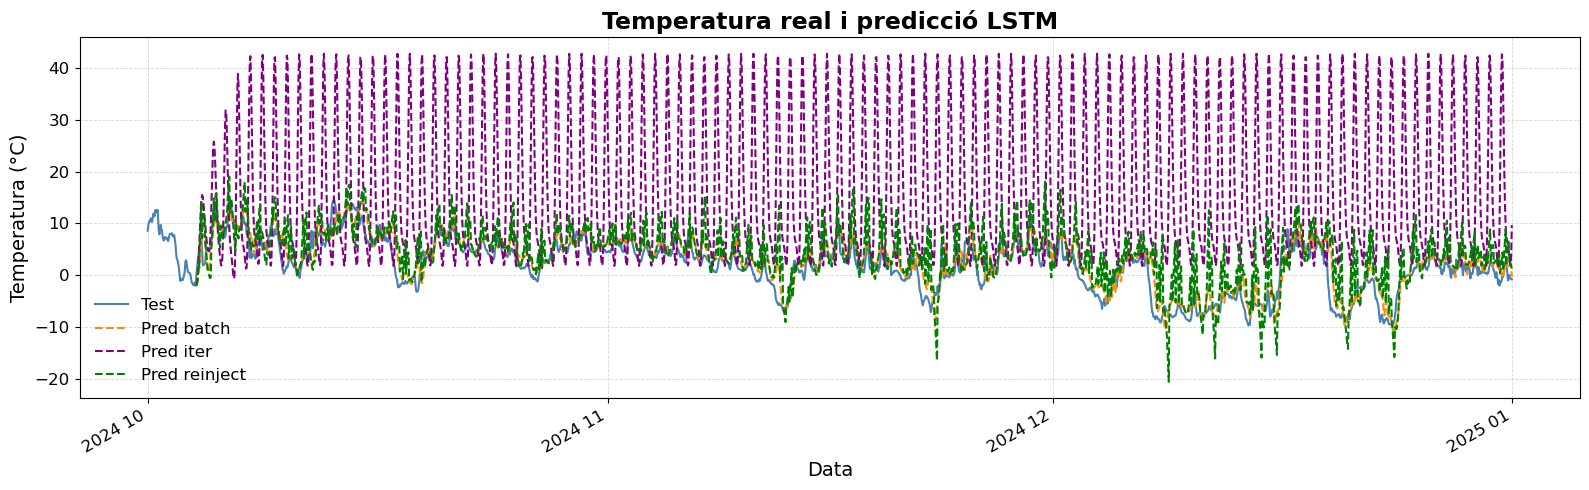


üìà M√®triques calculades:
         pred_batch  pred_iter  pred_reinject
M√®trica                                      
RMSE           2.38      20.34           4.49
MSE            5.69     413.83          20.14
MAE            1.82      15.04           3.38
üóÉÔ∏è [5/5] Guardant prediccions, m√®triques i configuraci√≥...
‚úÖ Experiment 3 completat i guardat a: /home/prp/Escriptori/TFM_SCM_Temperature_Forecasting_ML/models_prediccio/3_model_lstm/models_results_experiments_lookahead/experiment_3

üöÄ Executant experiment 4...
üß† [1/5] Entrenant el model LSTM...
‚úÖ Escalat completat:


Train dataset shape: (39432, 3)
Validation dataset shape: (2208, 3)
Test dataset shape: (2208, 3)
Entrenant el model LSTM
Epoch 1/50
52/52 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 46ms/step - loss: 0.0852 - val_loss: 0.0132
Epoch 2/50
52/52 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 42ms/step - loss: 0.0135 - val_loss: 0.0087
Epoch 3/50
52/52 ‚îÅ‚îÅ‚îÅ‚îÅ‚î

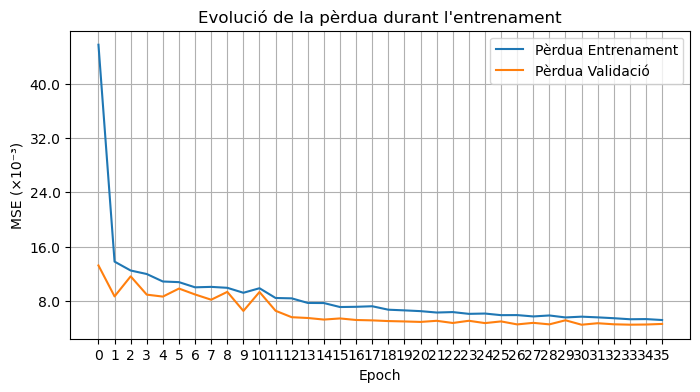

Entrenament completat.
üíæ [2/5] Guardant model i gr√†fica de p√®rdua...
üîÆ [3/5] Fent prediccions...
Fent predicci√≥ batch multi-output...
‚ö†Ô∏è Av√≠s: la columna 'pred_iter' no existeix a df_test_pred. Es descarta.
‚ö†Ô∏è Av√≠s: la columna 'pred_reinject' no existeix a df_test_pred. Es descarta.
üìä [4/5] Generant gr√†fic de prediccions...


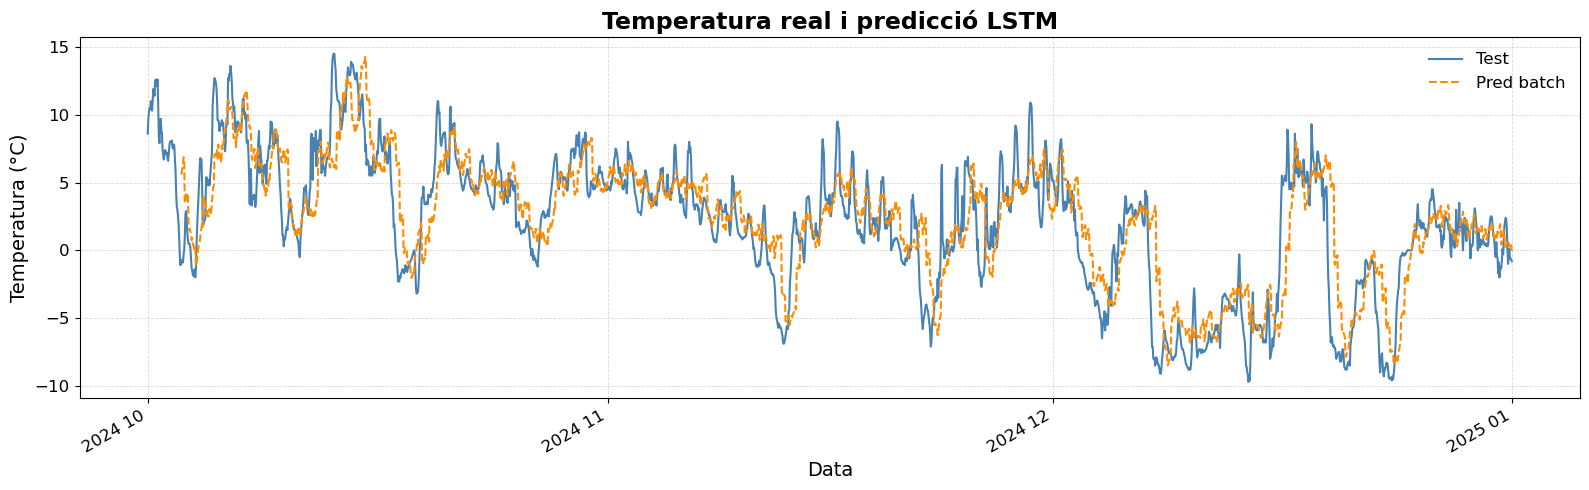


üìà M√®triques calculades:
         pred_batch
M√®trica            
RMSE           2.75
MSE            7.58
MAE            1.99
üóÉÔ∏è [5/5] Guardant prediccions, m√®triques i configuraci√≥...
‚úÖ Experiment 4 completat i guardat a: /home/prp/Escriptori/TFM_SCM_Temperature_Forecasting_ML/models_prediccio/3_model_lstm/models_results_experiments_lookahead/experiment_4

üöÄ Executant experiment 5...
üß† [1/5] Entrenant el model LSTM...
‚úÖ Escalat completat:


Train dataset shape: (39432, 3)
Validation dataset shape: (2208, 3)
Test dataset shape: (2208, 3)
Entrenant el model LSTM
Epoch 1/50
26/26 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 296ms/step - loss: 0.1101 - val_loss: 0.0200
Epoch 2/50
26/26 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 282ms/step - loss: 0.0159 - val_loss: 0.0075
Epoch 3/50
26/26 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 285ms/step - loss: 0.0121 - val_loss: 0.0077
Epoch 4/50
26/26 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

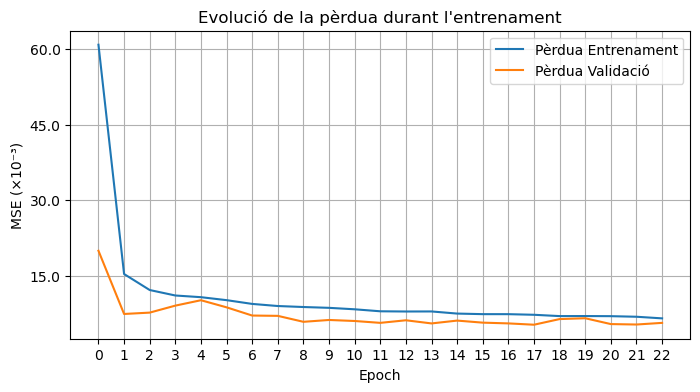

Entrenament completat.
üíæ [2/5] Guardant model i gr√†fica de p√®rdua...
üîÆ [3/5] Fent prediccions...
Fent predicci√≥ batch multi-output...
‚ö†Ô∏è Av√≠s: la columna 'pred_iter' no existeix a df_test_pred. Es descarta.
‚ö†Ô∏è Av√≠s: la columna 'pred_reinject' no existeix a df_test_pred. Es descarta.
üìä [4/5] Generant gr√†fic de prediccions...


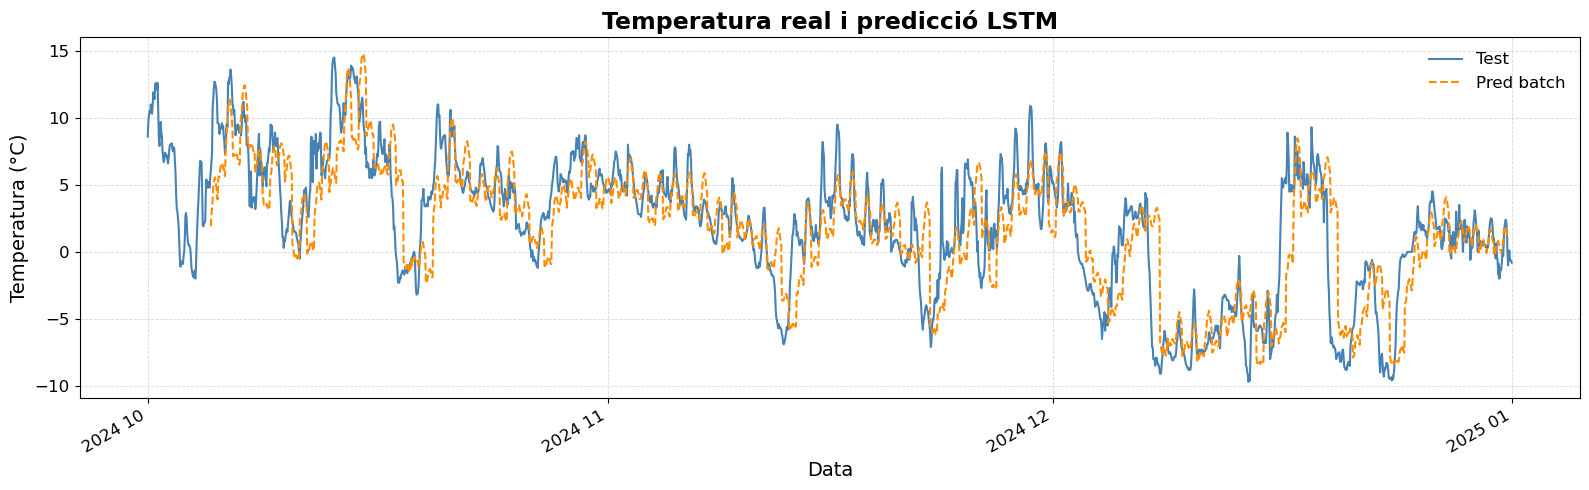


üìà M√®triques calculades:
         pred_batch
M√®trica            
RMSE           3.09
MSE            9.57
MAE            2.25
üóÉÔ∏è [5/5] Guardant prediccions, m√®triques i configuraci√≥...
‚úÖ Experiment 5 completat i guardat a: /home/prp/Escriptori/TFM_SCM_Temperature_Forecasting_ML/models_prediccio/3_model_lstm/models_results_experiments_lookahead/experiment_5


In [ ]:
for i in EXPERIMENTS:
    
    print(f"\nüöÄ Executant experiment {i}...")

    # Agafar par√†metres per aquest experiment
    window_size = WINDOW_SIZE[i]
    n_outputs = N_OUTPUTS[i]
    n_layers = N_LAYERS[i]
    n_units = N_UNITS[i]

    # Nom de la carpeta per a l'experiment
    carpeta_exp = f"experiment_{i}"
    path_experiment = os.path.join(__path__, carpeta_resultats, carpeta_exp)
    os.makedirs(path_experiment, exist_ok=True)

    
    # Executar pipeline
    model, scaler, df_train, df_val, df_test_pred, history, metriques, fig, fig_loss_train = pipeline_lstm(
        df_lstm=df_lstm,
        window_size=window_size,
        n_outputs=n_outputs,
        lookahead=LOOKAHEAD,
        n_layers=n_layers,
        n_units=n_units,
        dropout_rate=DROPOUT_RATE,
        optimizer='adam',
        loss='mse',
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        patience=PATIENCE,
        shuffle=False,
        seed=42,
        dies_train=0,
        mostrar_val=False,
        col_preds= PREDICTIONS_MOD,
        save_path=path_experiment,
        show=True,
        summary=False
    )

    print(f"‚úÖ Experiment {i} completat i guardat a: {path_experiment}")


## Experiments amb lookahead 12

| ID | `window_size` | `n_outputs` | `n_layers` | `n_units` | `dropout` | `lookahead` | Estrat√®gies de predicci√≥      |
| -- | ------------- | ----------- | ---------- | --------- | --------- | ----------- | ----------------------------- |
| 0  | 24            | 1           | 1          | 1         | 0.2       | 12          | `pred_batch`, `pred_reinject` |
| 1  | 24            | 1           | 1          | 32        | 0.2       | 12          | `pred_batch`, `pred_reinject` |
| 2  | 48            | 1           | 2          | 64        | 0.2       | 12          | `pred_batch`, `pred_reinject` |
| 3  | 72            | 1           | 3          | 128       | 0.2       | 12          | `pred_batch`, `pred_reinject` |
| 4  | 48            | 6           | 2          | 64        | 0.2       | 12          | `pred_batch`, `pred_reinject` |
| 5  | 96            | 12          | 3          | 128       | 0.2       | 12          | `pred_batch`, `pred_reinject` |
